In [1]:
import sklearn
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math

C:\Users\giuli\anaconda3\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


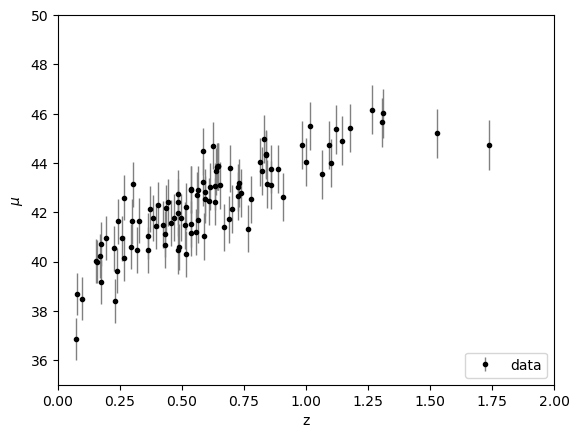

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

# Linear regression

In [3]:
n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
split = kf.split(z_sample)

In [4]:
model = LinearRegression()

accur = []
for i, (train_index, test_index) in zip(range(n_splits),split):
    X_train = z_sample[train_index]
    y_train = mu_sample[train_index]
    err_train = dmu[train_index] 

    X_test = z_sample[test_index]
    y_test = mu_sample[test_index]
    err_test = dmu[test_index]
    
    model.fit(X_train[:,np.newaxis], y_train, err_train)

    acc = model.score(X_test[:,np.newaxis],y_test)
    print(f"Fold {i}: accuracy on the validation set ", acc)
    accur.append(acc)

print('Average accuracy = ', np.sum(np.array(accur))/len(accur))

Fold 0: accuracy on the validation set  0.7105849530830317
Fold 1: accuracy on the validation set  0.5994737653834574
Fold 2: accuracy on the validation set  0.3846260987843616
Fold 3: accuracy on the validation set  0.7269525654052196
Fold 4: accuracy on the validation set  0.7172042060646162
Average accuracy =  0.6277683177441372


# Polynomial regression

Let's fit our data with a polynomial. First, let's do multiple fits changing the degree of the polynomial.

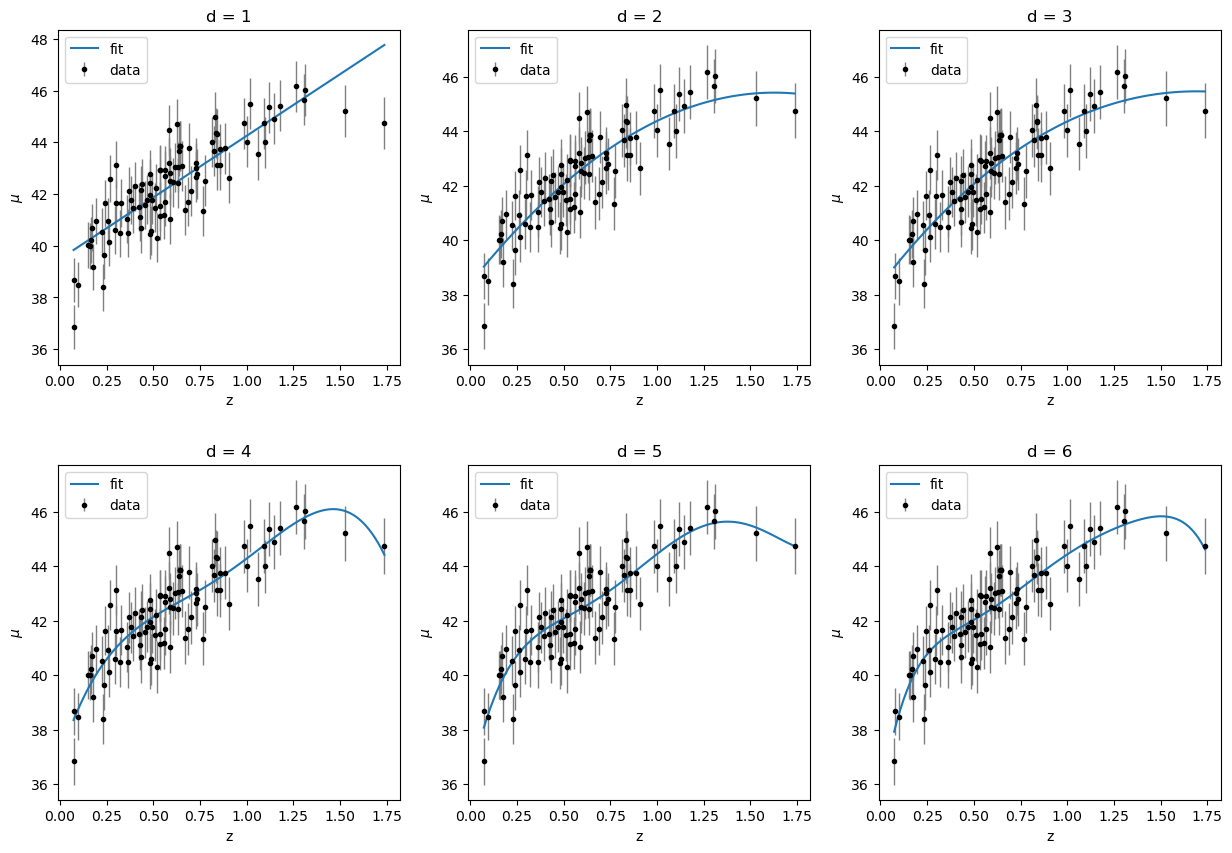

In [5]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
fig.subplots_adjust(hspace= 0.3)
x_plot = np.linspace(np.min(z_sample),np.max(z_sample),100)

model = PolynomialRegression(1)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,0].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,0].set_title('d = 1')
axes[0,0].set_xlabel('z')
axes[0,0].set_ylabel(r"$\mu$")
axes[0,0].legend()

model = PolynomialRegression(2)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,1].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,1].set_title('d = 2')
axes[0,1].set_xlabel('z')
axes[0,1].set_ylabel(r"$\mu$")
axes[0,1].legend()

model = PolynomialRegression(3)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,2].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,2].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,2].set_title('d = 3')
axes[0,2].set_xlabel('z')
axes[0,2].set_ylabel(r"$\mu$")
axes[0,2].legend()

model = PolynomialRegression(4)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,0].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,0].set_title('d = 4')
axes[1,0].set_xlabel('z')
axes[1,0].set_ylabel(r"$\mu$")
axes[1,0].legend()

model = PolynomialRegression(5)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,1].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,1].set_title('d = 5')
axes[1,1].set_xlabel('z')
axes[1,1].set_ylabel(r"$\mu$")
axes[1,1].legend()

model = PolynomialRegression(6)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,2].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,2].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,2].set_title('d = 6')
axes[1,2].set_xlabel('z')
axes[1,2].set_ylabel(r"$\mu$")
axes[1,2].legend()

plt.show()

It looks likes $d=2$ and $d=3$ are the best fit. With $d=1$ we underfit our data, with $d>3$ we overfit it.
\
The hyperparameter of our fit is the degree $d$ of the polynomial. Let's use cross-validation to tune this hyperparameter. In particular, we use GridSearchCV and fold our dataset 5 times.

In [6]:
degree = np.linspace(1,10,10,dtype=int)
model = PolynomialRegression()
grid = GridSearchCV(model, {'degree': degree}, scoring = 'r2', cv= 5) 
grid.fit(z_sample[:,np.newaxis],mu_sample)
print('Best iperparameter: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best iperparameter:  {'degree': 2}
Best score:  0.6939756807052869


So, $d=2$ is the value that maximises the score. Let's plot our final fit.

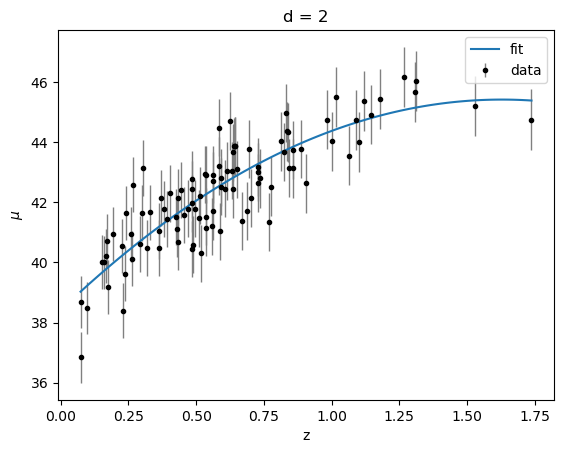

In [7]:
model = PolynomialRegression(2)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('d = 2')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

# Basis Function Regression

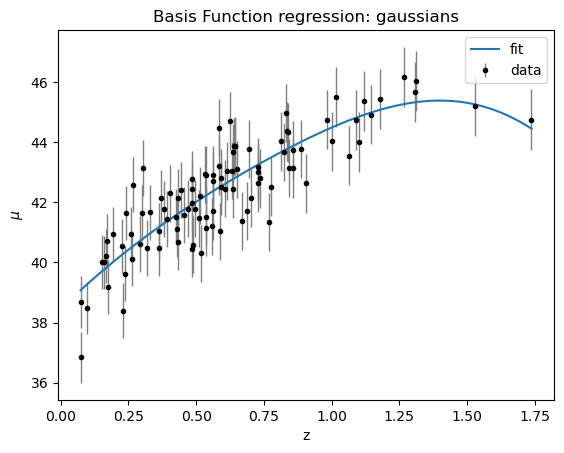

In [8]:
mu = np.linspace(np.min(z_sample),np.max(z_sample),2)[:,None]
sigma = 0.9
model = BasisFunctionRegression('gaussian',mu=mu,sigma=sigma)
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Basis Function regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

In [ ]:
class GaussianBasisFunctions(BaseEstimator, TransformerMixin):
    def __init__(self, n_basis_funcs=10, width=1.0):
        self.n_basis_funcs = n_basis_funcs
        self.width = width

    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.n_basis_funcs)
        return self

    def transform(self, X):
        x =  np.exp(-0.5 * ((X[:, :, np.newaxis] - self.centers_) / self.width) ** 2)
        # Reshape to 2D: (n_samples, n_basis_funcs)
        return x.reshape(x.shape[0], -1)

In [ ]:
pipeline = Pipeline([
    ('basis', GaussianBasisFunctions()),
    ('regressor', LinearRegression())
])

In [ ]:
basis_val = np.linspace(1,10,10,dtype=int)
sigma_val = np.arange(0.5,1.5,0.01)

param = {'basis__n_basis_funcs': basis_val, 'basis__width': sigma_val}

grid = GridSearchCV(pipeline, param, scoring = 'r2', cv= 5) 
grid.fit(z_sample[:,np.newaxis],mu_sample)
print('Best hyperparameters: ', grid.best_params_)
print('Best score: ', grid.best_score_)

In [ ]:
mu = np.linspace(np.min(z_sample),np.max(z_sample),2)[:,None]
sigma = 0.8
model = BasisFunctionRegression('gaussian',mu=mu,sigma=sigma)
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Basis Function regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

# Kernel Regression

In [ ]:
model = NadarayaWatson(kernel='gaussian', h=0.09)
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Kernel regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

In [ ]:
class Kernel(BaseEstimator, RegressorMixin):
    def __init__(self, h=1.0):
        self.h = h

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        K = pairwise_kernels(X, self.X, metric='rbf', gamma=1 / (2 * self.h ** 2))
        return (K * self.y).sum(1) / K.sum(1)

In [ ]:
h_val = np.arange(0.01,0.2,0.01)
grid = GridSearchCV(Kernel(), {'h': h_val}, scoring = 'r2', cv= 5) 
grid.fit(z_sample[:,np.newaxis],mu_sample)
print('Best hyperparameters: ', grid.best_params_)
print('Best score: ', grid.best_score_)

In [ ]:
model = NadarayaWatson(kernel='gaussian', h=0.03)
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Kernel regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()